In [1]:
using DrWatson
@quickactivate "TriangularHubbard"

using DataStructures
using CodecXz
using SQLite
using DBInterface
using DataFrames
using Printf
using LsqFit
using ProgressMeter
using Quadmath
using Statistics
using ProgressMeter
using JSON
using LinearAlgebra

using PyPlot
using PyCall
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

  Activating project at `/data/pn1_1/klee/Projects/TriangularHubbard`


PyObject <module 'seaborn' from '/home/klee/.pyenv/versions/conda_jl/lib/python3.7/site-packages/seaborn/__init__.py'>

In [2]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [11]:
n_sites = 12
shape_str = "(2,-2)x(2,4)"
t = 1.0
U = 20.0

20.0

In [12]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end
shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end
phases = cis.(-2π * momentums' * sitecoordinates)
;

In [13]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, (n_sites, 1))
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

In [14]:
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
isfile(sectors_filepath)

true

In [15]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df1 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 0 as sparsetype
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=? AND sectors.idx=5480
    """, (t, U))
)
df2 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 1 as sparsetype
        FROM sparse_results_collection
        INNER JOIN sectors
        ON sparse_results_collection.idx = sectors.idx
        WHERE hopping=? AND interaction=? AND sectors.idx=5480
    """, (t, U))
)
DBInterface.close!(conn)

In [16]:
df1

109×9 DataFrame
 Row │ nup    ndn    dim    temperature  partition     spin_correlation        ⋯
     │ Int64  Int64  Int64  Float64      Float64       String                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    10      6   2536         0.01  0.0           [0.0,0.0,0.0,0.0]       ⋯
   2 │    10      6   2536         0.02  0.0           [0.0,0.0,0.0,0.0]
   3 │    10      6   2536         0.03  0.0           [0.0,0.0,0.0,0.0]
   4 │    10      6   2536         0.04  0.0           [0.0,0.0,0.0,0.0]
   5 │    10      6   2536         0.05  0.0           [0.0,0.0,0.0,0.0]       ⋯
   6 │    10      6   2536         0.06  0.0           [0.0,0.0,0.0,0.0]
   7 │    10      6   2536         0.07  0.0           [0.0,0.0,0.0,0.0]
   8 │    10      6   2536         0.08  0.0           [0.0,0.0,0.0,0.0]
   9 │    10      6   2536         0.09  0.0           [0.0,0.0,0.0,0.0]       ⋯
  10 │    10      6   2536         0.1   4.26801e-297  [7.0355559772381445e-29
  11 │    10      6   2536         0.2   6.56339e-149  [1.0819459509450415e-14
  ⋮  │   ⋮      ⋮      ⋮         ⋮            ⋮                        ⋮       ⋱
 100 │    10      6   2536         9.1   0.127333      [0.019901750447397892,0
 101 │    10      6   2536         9.2   0.14047       [0.021928273539909518,0 ⋯
 102 │    10      6   2536         9.3   0.154658      [0.024113525795374183,0
 103 │    10      6   2536         9.4   0.169952      [0.026465897170482637,0
 104 │    10      6   2536         9.5   0.186412      [0.028993962177616812,0
 105 │    10      6   2536         9.6   0.204098      [0.031706472401894156,0 ⋯
 106 │    10      6   2536         9.7   0.223072      [0.03461234875223882,0.
 107 │    10      6   2536         9.8   0.243396      [0.037720673474973744,0
 108 │    10      6   2536         9.9   0.265134      [0.041040681957951186,0
 109 │    10      6   2536        10.0   0.288352      [0.04458175435266091,0. ⋯
                                                   4 columns and 88 rows omitted

In [19]:
conv(x::AbstractArray) = conv.(x)
function conv(x::AbstractDict)
    if keys(x) == Set(["re", "im"])
        r = conv(x["re"])
        i = conv(x["im"])
        r = isnothing(r) ? NaN : r
        i = isnothing(i) ? NaN : i
        return complex(r, i)
    else
        return Dict(k => conv(v) for (k, v) in x)
    end
end
conv(x::Number) = x
conv(x::AbstractString) = x
conv(x::Nothing) = NaN

conv (generic function with 5 methods)

In [32]:
szsz1 = []
for (irow, row) in enumerate(eachrow(df1))
    push!(szsz1, conv(JSON.parse(row[:spin_correlation]))[2])
end


In [33]:
szsz2 = []
for (irow, row) in enumerate(eachrow(df2))
    push!(szsz2, conv(JSON.parse(row[:spin_correlation]))[2])
end


In [34]:
szsz1

109-element Vector{Any}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 9.946531748395118e-299
 1.5271181845087838e-150
 3.877933272096483e-101
 2.0402446407898964e-76
 ⋮
 0.0016966776149874392
 0.0018815602345928488
 0.002082184634039534
 0.002299488925736062
 0.0025344389116447714
 0.002788027489529328
 0.0030612740098138872
 0.003355223585875012
 0.003670946360644771
 0.004009536732443337
 0.004372112542983322
 0.00475981423049709

In [37]:
szsz2

109-element Vector{Any}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 9.657938071523708e-299
 1.482385272472545e-150
 3.7629129117909524e-101
 1.9803107443245662e-76
 ⋮
 0.0016966798067046165
 0.0018815654052655982
 0.0020821930846939025
 0.0022995009557965265
 0.0025344548159302
 0.002788047555062648
 0.003061298512456
 0.00335525278679439
 0.003670980502634655
 0.004009576036099219
 0.004372157202753548
 0.004759864410619989

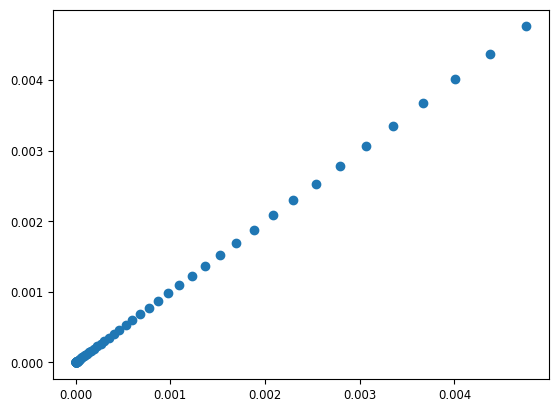

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe51ad2ded0>

In [36]:
PyPlot.plot(szsz1, szsz2, "o")

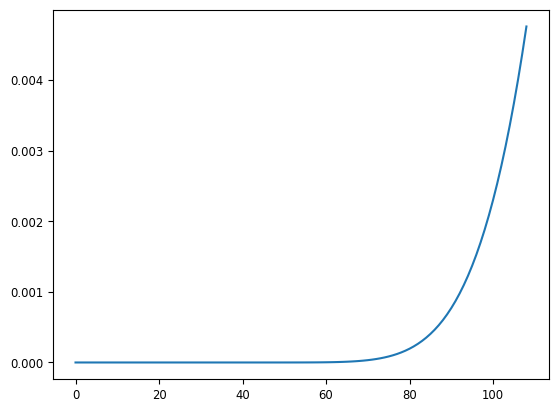

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe51ad1be90>

In [38]:
PyPlot.plot(szsz1)